# Visualize the activations of VGG and the Discriminator
We gave two loss functions that extract layers from hhv VGG and our discriminator to use. This is a visualization of what the output of those layers look like

In [22]:
import matplotlib.pyplot as plt

import torch
from torchvision import models
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.io import read_image

In [36]:
import sys
sys.path.append("..")
from model import Discriminator, Generator
from config import Config
from loss import ContentLossDiscriminator
from bicubic import Bicubic
from utils import load_state_dict

In [ ]:
def common_entries(*dcts):
    """https://stackoverflow.com/a/16458780/19877091"""
    if not dcts:
        return
    for i in set(dcts[0]).intersection(*dcts[1:]):
        yield (i,) + tuple(d[i] for d in dcts)

In [42]:
c = Config()
b = Bicubic()

# Gernetaor
g = Generator(c)
w = torch.load("/zhome/c9/c/156514/SRGAN-ST/results/patchwise-st-cd-no-pixel/g_best.pth", map_location='cpu')
g = load_state_dict(g,w)

# Disciminator
d = Discriminator(c)
weights = torch.load("/zhome/c9/c/156514/SRGAN-ST/results/discriminator-lorna-pretrained.pth")
d.load_state_dict(weights)

# Read image
im_path = "/work3/s204163/data/Set5/GTmod12/butterfly.png" # "/work3/s204163/data/Set14/GTmod12/baboon.png"
gt = read_image(im_path).float().unsqueeze(0) / 255.0

# Create sr version
lr = b(gt, scale=0.25)
with torch.no_grad():
    sr = g(lr)

# VGG19

In [43]:
vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
# print(vgg)

In [44]:
extraction_layers = [
    "features.17",
    "features.26",
    "features.35"
]
feature_extractor = create_feature_extractor(vgg, extraction_layers)

# Freeze model parameters.
for model_parameters in feature_extractor.parameters():
    model_parameters.requires_grad = False

# Set to validation mode
feature_extractor = feature_extractor.eval()

In [46]:
gt_activations = feature_extractor(gt)
sr_activations = feature_extractor(sr)

for name, act_gt, act_sr in common_entries(gt_activations, sr_activations):
    fig, axes = plt.subplots(ncols=2)
    axes[0].imshow(act_gt.squeeze().sum(axis=0).numpy())
    axes[0].set_title(f"GT {name}")
    axes[1].imshow(act_sr.squeeze().sum(axis=0).numpy())
    axes[1].set_title(f"SR {name}")
    plt.show()

### Discriminator loss

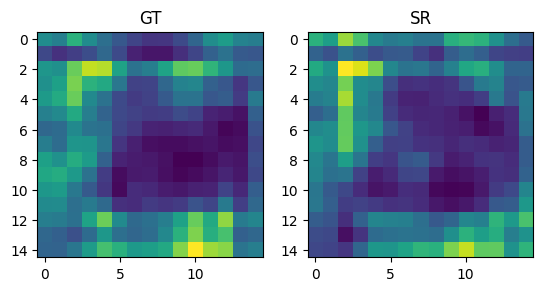

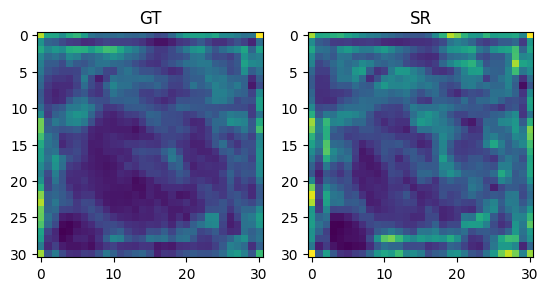

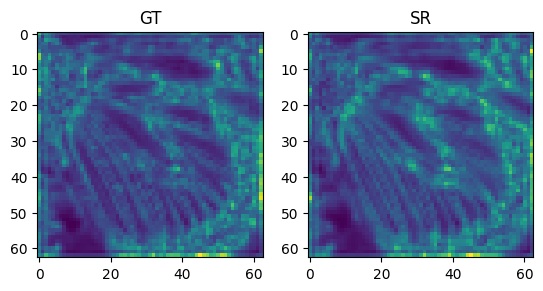

In [58]:
extraction_layers = [
    "features.4",
    "features.10"
]

feature_extractor = create_feature_extractor(d, extraction_layers)

# Freeze model parameters.
for model_parameters in feature_extractor.parameters():
    model_parameters.requires_grad = False

# Set to validation mode
feature_extractor = feature_extractor.eval()

In [59]:
gt_activations = feature_extractor(gt)
sr_activations = feature_extractor(sr)

for name, act_gt, act_sr in common_entries(gt_activations, sr_activations):
    fig, axes = plt.subplots(ncols=2)
    axes[0].imshow(act_gt.squeeze().sum(axis=0).numpy())
    axes[0].set_title(f"GT {name}")
    axes[1].imshow(act_sr.squeeze().detach().sum(axis=0).numpy())
    axes[1].set_title(f"SR {name}")
    plt.show()

<All keys matched successfully>

### Save activations of one layer as images
#### VGG

In [60]:
feature_extractor = create_feature_extractor(vgg, ["features.17"])

# Freeze model parameters.
for model_parameters in feature_extractor.parameters():
    model_parameters.requires_grad = False

# Set to validation mode
feature_extractor = feature_extractor.eval()

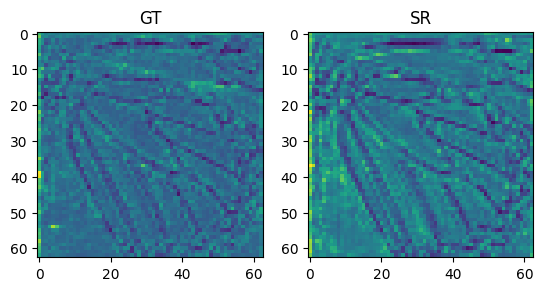

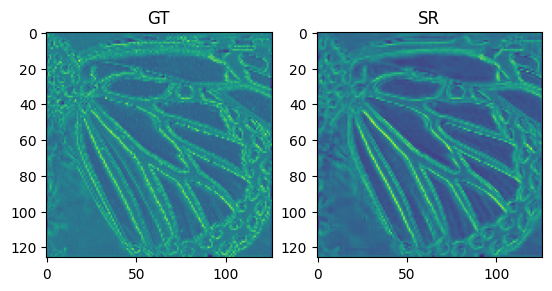

In [61]:
gt_activations = feature_extractor(gt)
sr_activations = feature_extractor(sr)

for layer_name, act_gt, act_sr in common_entries(gt_activations, sr_activations):
    for name, acts in zip(["gt","sr"], [act_gt, act_sr]):
        acts = acts.squeeze().sum(axis=0)
        norm = (acts - torch.min(acts)) / (torch.max(acts) - torch.min(acts)) * 255
        plt.axis("off")
        plt.imshow(norm)
        plt.savefig(f"plots/acts_vgg19_{name}_{layer_name}.png", bbox_inches='tight')
        # plt.show()
    

### Discriminator

In [ ]:
feature_extractor = create_feature_extractor(d, ["features.10"])

# Freeze model parameters.
for model_parameters in feature_extractor.parameters():
    model_parameters.requires_grad = False

# Set to validation mode
feature_extractor = feature_extractor.eval()

In [ ]:
gt_activations = feature_extractor(gt)
sr_activations = feature_extractor(sr)

for layer_name, act_gt, act_sr in common_entries(gt_activations, sr_activations):
    for name, acts in zip(["gt","sr"], [act_gt, act_sr]):
        acts = acts.squeeze().sum(axis=0)
        norm = (acts - torch.min(acts)) / (torch.max(acts) - torch.min(acts)) * 255
        plt.axis("off")
        plt.imshow(norm)
        plt.savefig(f"plots/acts_discriminator_{name}_{layer_name}.png", bbox_inches='tight')
        # plt.show()
    

### Also save GT

In [ ]:
plt.axis("off")
plt.imshow(gt.squeeze().permute(1,2,0))
plt.savefig(f"plots/acts_gt.png", bbox_inches='tight')
plt.show()